In [2]:
import os
import sys
# Add the src directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
from src.data_handling.historical_data_handler import SingleSymbolDataHandler
from src.feature_engineering.feature_extractor import SingleSymbolFeatureExtractor
%cd $project_root

/Users/zhaoyub/Documents/Tradings/tradebotv3


/Users/zhaoyub/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [42]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.8f' % x)
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import datetime
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [68]:
datahandler = SingleSymbolDataHandler('BTCUSDT')
inter, begin, end = '4h', '2022-01-01', '2025-03-04'
datahandler.load_data(inter, begin, end)
BTC_indicator = SingleSymbolFeatureExtractor('BTCUSDT', datahandler)
BTC_indicator.load_full_range()
indicators = BTC_indicator.indicators
datahandler.cleaned_data['close'] = datahandler.cleaned_data['close']
indicators = pd.concat([indicators,datahandler.cleaned_data[['close', 'volume']]],axis= 1)

In [69]:
indicators.columns

Index(['rsi', 'macd', 'macd_signal', 'macd_diff', 'stoch_k', 'stoch_d',
       'bollinger_mavg', 'bollinger_upper', 'bollinger_lower', 'atr', 'vwap',
       'obv', 'sma', 'ema', 'adx', 'close', 'volume'],
      dtype='object')

In [70]:
# indicators.head(20)

In [71]:
def compute_performance_metrics(trades, capital_series, indicators, initial_capital=1000):
    """
    Computes performance metrics based on the executed trades and capital evolution.
    
    Metrics include:
      - Total ROI (%)
      - Max Drawdown (%)
      - Sharpe Ratio (using period returns from the capital series)
      - Symbol ROI (%) based on the close price changes
      - Trade Efficiency (%)
      - Trade Distribution (winning and losing trades and win rate)
      - Profit Attribution (total, average, max, and min profit)
      - Risk Reward Ratio: average win / average loss (absolute)
      - Total Trades: count of completed trades (sell orders)
      - Largest Win Trade (%): best winning trade profit
      - Largest Lost Trade (%): worst trade profit
      - Sortino Ratio: risk-adjusted return using downside volatility
      
    Parameters:
        trades (list): List of trade dictionaries.
        capital_series (pd.Series): Series of capital values over time.
        indicators (pd.DataFrame): DataFrame that contains the 'close' price column.
        initial_capital (float): Starting capital.
    
    Returns:
        dict: Dictionary with performance metrics.
    """
    # Total ROI (%)
    final_capital = capital_series.iloc[-1]
    total_roi = ((final_capital - initial_capital) / initial_capital) * 100

    # Max Drawdown (%)
    running_max = capital_series.cummax()
    drawdowns = (capital_series - running_max) / running_max
    max_drawdown = abs(drawdowns.min()) * 100
    
    # Compute returns from capital series (assume equal time intervals)
    returns = capital_series.pct_change().dropna()
    sharpe_ratio = returns.mean() / returns.std() if returns.std() != 0 else np.nan

    # Symbol ROI (%) based on the underlying asset's price
    initial_price = indicators['close'].iloc[0]
    final_price = indicators['close'].iloc[-1]
    symbol_roi = ((final_price - initial_price) / initial_price) * 100

    # Trade Efficiency (%) = (net profit / total absolute profit) * 100
    trade_profits = [t['profit'] for t in trades if t.get('type') == 'sell' and 'profit' in t]
    total_profit = sum(trade_profits)
    gross_profit = sum(abs(p) for p in trade_profits) if trade_profits else 0
    trade_efficiency = (total_profit / gross_profit * 100) if gross_profit != 0 else np.nan

    # Trade Distribution: count winning, losing trades and win rate.
    winning_trades = [p for p in trade_profits if p > 0]
    losing_trades = [p for p in trade_profits if p < 0]
    win_rate = (len(winning_trades) / len(trade_profits) * 100) if trade_profits else np.nan
    trade_distribution = {
        'winning_trades': len(winning_trades),
        'losing_trades': len(losing_trades),
        'win_rate (%)': win_rate
    }
    
    # Profit Attribution: total, average, maximum, and minimum profit per trade.
    profit_attribution = {
        'total_profit': total_profit,
        'average_profit': (total_profit / len(trade_profits)) if trade_profits else 0,
        'max_profit': max(trade_profits) if trade_profits else 0,
        'min_profit': min(trade_profits) if trade_profits else 0
    }
    
    # Additional Metrics
    # Total Trades: count of completed trades (sell orders with a profit key)
    total_trades = len([t for t in trades if t.get('type') == 'sell' and 'profit' in t])
    
    # Risk Reward Ratio: ratio of average winning trade profit to average losing trade profit (absolute)
    avg_win = np.mean([p for p in trade_profits if p > 0]) if winning_trades else np.nan
    avg_loss = np.mean([abs(p) for p in trade_profits if p < 0]) if losing_trades else np.nan
    risk_reward_ratio = (avg_win / avg_loss) if (avg_loss and avg_loss > 0) else np.nan

    # Largest Win Trade (%)
    largest_win_trade = np.max([p for p in trade_profits if p > 0]) if winning_trades else np.nan
    
    # Largest Lost Trade (%)
    largest_lost_trade = np.min([p for p in trade_profits if p < 0]) if losing_trades else np.nan

    # Sortino Ratio calculation:
    # Assuming a daily frequency; use 252 trading days for annualization.
    risk_free_rate = 0.02
    annualization_factor = 252
    target = (1 + risk_free_rate) ** (1 / annualization_factor) - 1
    downside_returns = returns[returns < target]
    downside_std = downside_returns.std() if not downside_returns.empty else 0
    sortino_ratio = (returns.mean() - target) / downside_std if downside_std > 0 else np.nan

    # Compile all metrics into one dictionary
    metrics = {
        'Total ROI (%)': total_roi,
        'Max Drawdown (%)': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
        'Symbol ROI (%)': symbol_roi,
        'Trade Efficiency (%)': trade_efficiency,
        'Trade Distribution': trade_distribution,
        'Profit Attribution': profit_attribution,
        'Risk Reward Ratio': risk_reward_ratio,
        'Total Trades': total_trades,
        'Largest Win Trade (%)': largest_win_trade,
        'Largest Lost Trade (%)': largest_lost_trade,
        'Sortino Ratio': sortino_ratio
    }
    
    return metrics
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

def plot_price_and_capital(indicators, capital_series):
    """
    Plots both the asset's price (from indicators['close']) and the capital evolution on the same figure.
    
    Parameters:
        indicators (pd.DataFrame): DataFrame containing at least the 'close' column for asset prices.
        capital_series (pd.Series): Series representing the evolution of capital over time.
    """
    # Ensure the capital_series index is timezone naive and normalized (date only)
    if isinstance(capital_series.index, pd.DatetimeIndex):
        if capital_series.index.tz is not None:
            capital_series.index = capital_series.index.tz_localize(None)
    else:
        capital_series.index = pd.to_datetime(capital_series.index, errors='coerce')
    capital_series.index = capital_series.index.normalize()
    
    # Also, ensure the indicators index is timezone naive and normalized
    if isinstance(indicators.index, pd.DatetimeIndex):
        if indicators.index.tz is not None:
            indicators.index = indicators.index.tz_localize(None)
    else:
        indicators.index = pd.to_datetime(indicators.index, errors='coerce')
    indicators.index = indicators.index.normalize()
    
    # Create a figure and a primary axis for capital
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    color_capital = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Capital', color=color_capital)
    ax1.plot(capital_series.index, capital_series.values, label='Capital', color=color_capital)
    ax1.tick_params(axis='y', labelcolor=color_capital)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Create a secondary axis for the price
    ax2 = ax1.twinx()
    color_price = 'tab:red'
    ax2.set_ylabel('Price', color=color_price)
    ax2.plot(indicators.index, indicators['close'], label='Price', color=color_price)
    ax2.tick_params(axis='y', labelcolor=color_price)
    
    # Improve layout and rotate dates
    fig.autofmt_xdate()
    fig.tight_layout()
    
    plt.title('Capital and Price Evolution Over Time')
    plt.grid(True)
    plt.show()

# Example usage:
# plot_price_and_capital(indicators_2, capital_series)

def plot_capital(capital_series):
    """
    Plots the evolution of capital over time with simplified date formatting.
    
    Parameters:
        capital_series (pd.Series): Capital values with a time/index.
    """
    # Check if the index is numeric (e.g., Unix epoch seconds)
    if isinstance(capital_series.index, pd.DatetimeIndex):
        if capital_series.index.tz is not None:
            capital_series.index = capital_series.index.tz_localize(None)
    else:
        # Otherwise, attempt to convert the index to datetime.
        capital_series.index = pd.to_datetime(capital_series.index, errors='coerce')
    
    # If conversion failed (NaT values), print a warning
    if capital_series.index.isnull().any():
        print("Warning: Some index values could not be converted to datetime. Check your index format.")
    
    # Normalize the dates to remove time components
    capital_series.index = capital_series.index.normalize()
    
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    capital_series.plot(ax=ax, label='Capital', color='blue')
    
    # Format the x-axis to show only the date (Year-Month-Day)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Rotate date labels for clarity
    
    plt.xlabel('Time')
    plt.ylabel('Capital')
    plt.title('Capital Evolution Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()

## VIDIA Model

Total ROI (%): -22.636164691015097
Max Drawdown (%): 58.08310398013226
Sharpe Ratio: -2.4415235271748934e-06
Symbol ROI (%): 79.40179265677203
Trade Efficiency (%): -3.3045026260243464
Trade Distribution: {'winning_trades': 149, 'losing_trades': 430, 'win_rate (%)': 25.734024179620036}
Profit Attribution: {'total_profit': -226.36164691015102, 'average_profit': -0.39095275804862006, 'max_profit': 134.75161962926916, 'min_profit': -60.00332612097543}
Risk Reward Ratio: 2.7012774162277418
Total Trades: 579
Largest Win Trade (%): 134.75161962926916
Largest Lost Trade (%): -60.00332612097543
Sortino Ratio: -0.019925942950103703


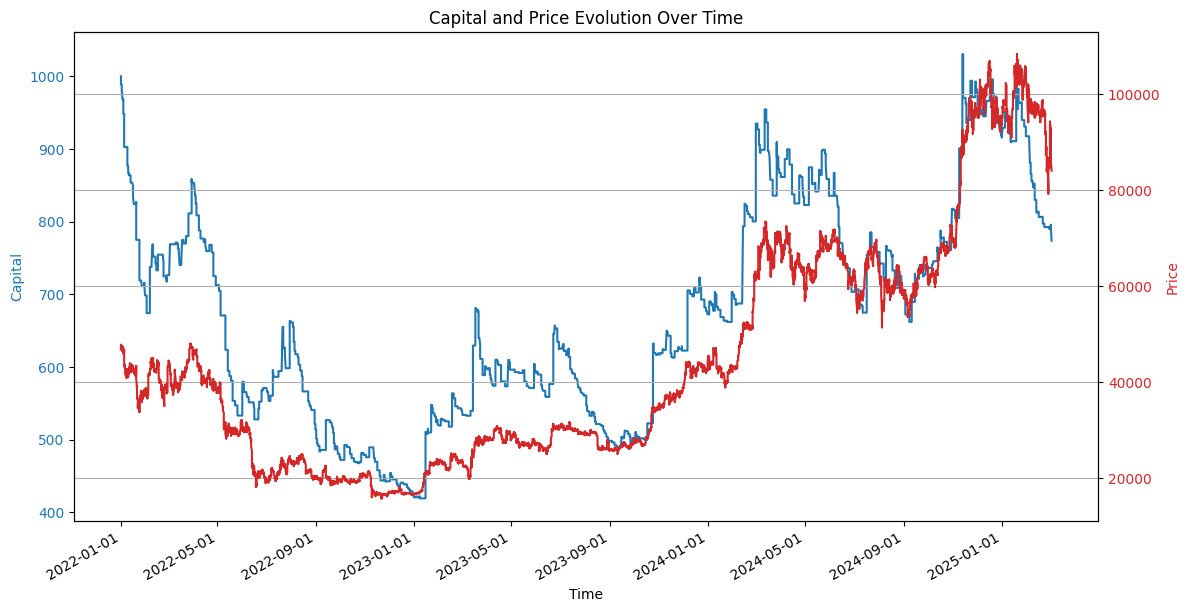

In [75]:
import pandas as pd
import numpy as np

def compute_vidya(src, length=50, window=9):
    """
    Computes VIDYA-related values from a price series.

    Parameters:
        src (pd.Series): Price series (for example, the 'close' prices).
        length (int): VIDYA length (default is 50).
        window (int): Lookback period for rolling sum calculations (default is 9).

    Returns:
        pd.Series: The computed VIDYA momentum indicator (vCMO).
        float: The computed valpha value.
        pd.Series: vud1 values (price increases).
        pd.Series: vdd1 values (price decreases).
    """
    # Calculate the smoothing constant
    valpha = 2 / (length + 1)
    
    # Previous price (shifted by one period)
    prev_src = src.shift(1)
    
    # Upward movement: difference only if current price > previous price; else 0.
    vud1 = (src - prev_src).where(src > prev_src, 0)
    
    # Downward movement: difference only if current price < previous price; else 0.
    vdd1 = (prev_src - src).where(src < prev_src, 0)
    
    # Rolling sums for up and down movements over the given window
    vUD = vud1.rolling(window=window, min_periods=1).sum()
    vDD = vdd1.rolling(window=window, min_periods=1).sum()
    
    # Calculate a CMO-like momentum indicator
    denominator = vUD + vDD
    vCMO = (vUD - vDD) / denominator.replace(0, np.nan)
    
    # Fill NaN values (from division by zero or initial periods) with 0
    vCMO = vCMO.fillna(0)
    
    return vCMO, valpha, vud1, vdd1

def dynamic_vidya_trading_with_threshold(indicators, fee=0.001, initial_capital=1000, threshold=0):
    """
    Simulates a VIDYA trading strategy using full capital investment with a threshold for the VIDYA indicator.
    
    The strategy enters a long position when the VIDYA indicator (vCMO) exceeds the threshold and exits 
    when it falls below the negative threshold. This helps filter out noise in the signals.
    
    Parameters:
        indicators (pd.DataFrame): DataFrame containing at least the following columns:
            ['rsi', 'macd', 'macd_signal', 'macd_diff', 'stoch_k', 'stoch_d',
             'bollinger_mavg', 'bollinger_upper', 'bollinger_lower', 'atr', 'vwap',
             'obv', 'sma', 'ema', 'adx', 'close', 'volume'].
        fee (float): Transaction fee as a fraction (default: 0.001, i.e. 0.1% fee).
        initial_capital (float): Starting capital.
        threshold (float): Threshold for the VIDYA indicator.
                           A buy signal is generated when vCMO > threshold and a sell signal when vCMO < -threshold.
    
    Returns:
        trades (list): List of executed trades (each is a dict with trade details).
        capital_series (pd.Series): Series of capital values over time, using the same index as indicators.
    """
    # Compute the VIDYA indicator from the 'close' price.
    vCMO, valpha, vud1, vdd1 = compute_vidya(indicators['close'], length=50, window=9)
    
    in_position = False   # Indicates if the strategy is currently in a trade
    capital = initial_capital
    position_size = 0     # Number of asset units purchased
    entry_capital = 0     # Capital allocated at entry
    trades = []           # List to record trades
    capital_record = []   # Capital evolution over time

    # Iterate over the indicator DataFrame
    for i in range(len(indicators)):
        current_vCMO = vCMO.iloc[i]
        current_price = indicators['close'].iloc[i]
        
        # Buy signal: if not in position and VIDYA indicator exceeds the threshold.
        if not in_position and current_vCMO > threshold:
            # Apply fee: fee increases the effective buying price.
            buy_price = current_price * (1 + fee)
            position_size = capital / buy_price
            entry_capital = capital
            in_position = True
            trades.append({
                'type': 'buy',
                'price': buy_price,
                'index': indicators.index[i]
            })
        
        # Sell signal: if in position and VIDYA indicator falls below the negative threshold.
        elif in_position and current_vCMO < -threshold:
            # Apply fee: fee decreases the effective selling price.
            sell_price = current_price * (1 - fee)
            new_capital = position_size * sell_price
            profit = new_capital - entry_capital
            capital = new_capital
            in_position = False
            trades.append({
                'type': 'sell',
                'price': sell_price,
                'index': indicators.index[i],
                'profit': profit
            })
        
        capital_record.append(capital)
    
    # If still holding a position at the end of the series, close it at the final price.
    if in_position:
        final_price = indicators['close'].iloc[-1] * (1 - fee)
        new_capital = position_size * final_price
        profit = new_capital - entry_capital
        capital = new_capital
        trades.append({
            'type': 'sell',
            'price': final_price,
            'index': indicators.index[-1],
            'profit': profit
        })
        capital_record[-1] = capital  # Update the final capital record

    # Create a pandas Series for capital evolution with the same index as the indicators.
    capital_series = pd.Series(capital_record, index=indicators.index)
    
    return trades, capital_series

trades, capital_series = dynamic_vidya_trading_with_threshold(indicators, fee=0.001, threshold=0)
metrics = compute_performance_metrics(trades, capital_series, indicators)
for key, value in metrics.items():
    print(f"{key}: {value}")
plot_price_and_capital(indicators, capital_series)


Total ROI (%): -54.486052983295785
Max Drawdown (%): 55.49126989265157
Sharpe Ratio: -0.033610787403397895
Symbol ROI (%): 79.40179265677203
Trade Efficiency (%): -15.045776101768944
Trade Distribution: {'winning_trades': 385, 'losing_trades': 868, 'win_rate (%)': 30.726256983240223}
Profit Attribution: {'total_profit': -544.8605298329586, 'average_profit': -0.4348447963551146, 'max_profit': 35.0911518521404, 'min_profit': -24.115788407486946}
Risk Reward Ratio: 1.664843037477225
Total Trades: 1253
Largest Win Trade (%): 35.0911518521404
Largest Lost Trade (%): -24.115788407486946
Sortino Ratio: -0.10434811363780842


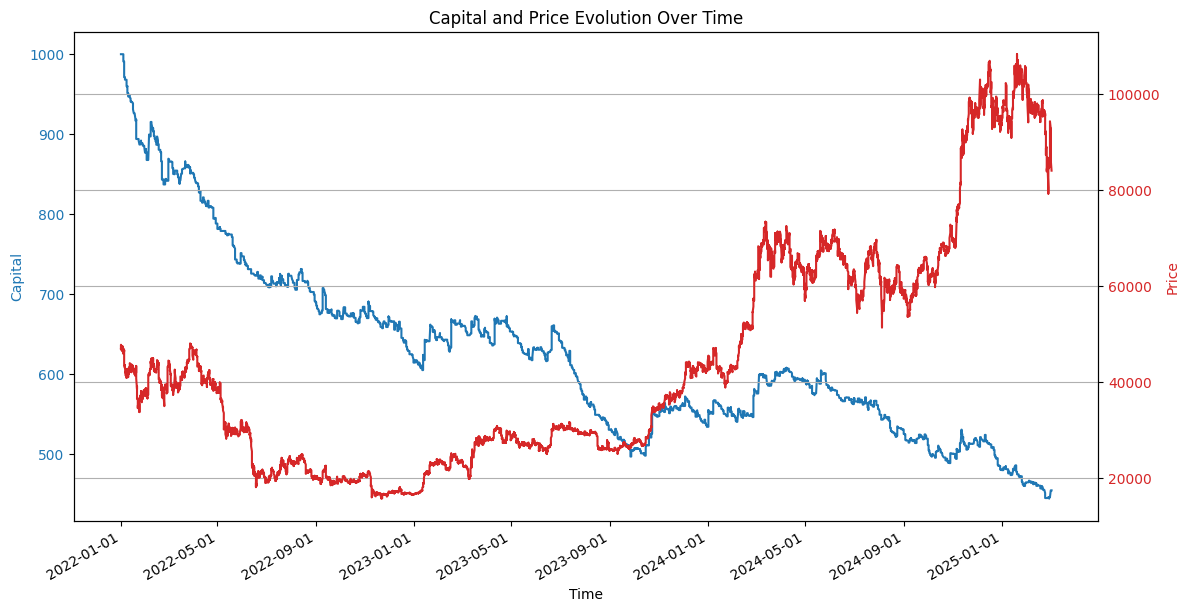

In [76]:
import pandas as pd
import numpy as np

def compute_vidya(src, length=50, window=9):
    """
    Computes VIDYA-related values from a price series.
    
    Parameters:
        src (pd.Series): Price series (e.g., the 'close' prices).
        length (int): VIDYA length (default is 50).
        window (int): Lookback period for rolling sum calculations (default is 9).
    
    Returns:
        pd.Series: The computed VIDYA indicator (vCMO).
        float: The computed valpha value.
        pd.Series: vud1 values (price increases).
        pd.Series: vdd1 values (price decreases).
    """
    # Smoothing constant
    valpha = 2 / (length + 1)
    prev_src = src.shift(1)
    
    # Upward and downward movements
    vud1 = (src - prev_src).where(src > prev_src, 0)
    vdd1 = (prev_src - src).where(src < prev_src, 0)
    
    # Rolling sums over the given window
    vUD = vud1.rolling(window=window, min_periods=1).sum()
    vDD = vdd1.rolling(window=window, min_periods=1).sum()
    
    denominator = vUD + vDD
    vCMO = (vUD - vDD) / denominator.replace(0, np.nan)
    vCMO = vCMO.fillna(0)
    
    return vCMO, valpha, vud1, vdd1

def improved_vidya_trading(
    indicators,
    fee=0.001,
    initial_capital=1000,
    rsi_threshold=50,
    atr_multiplier=1.5,
    risk_percentage=0.01,
    use_higher_tf=False,
    weekly_indicators=None
):
    """
    Implements an enhanced VIDYA-based trend strategy.
    
    Enhancements include:
      - Multi-timeframe confirmation (optional)
      - RSI filter to confirm momentum
      - ATR-based stop-loss and fixed-risk position sizing
      - Refined entry (VIDYA rising) and exit (VIDYA falling or stop-loss hit) conditions.
    
    Parameters:
        indicators (pd.DataFrame): Primary timeframe DataFrame containing at least:
            ['rsi', 'atr', 'close'] (plus other indicators if desired).
        fee (float): Transaction fee fraction (default 0.001 = 0.1%).
        initial_capital (float): Starting capital.
        rsi_threshold (float): Minimum RSI value for long entry.
        atr_multiplier (float): Multiplier for ATR to set stop-loss.
        risk_percentage (float): Fraction of current capital to risk on each trade.
        use_higher_tf (bool): Whether to use higher timeframe confirmation.
        weekly_indicators (pd.DataFrame): Weekly timeframe DataFrame (with at least 'close')
            for computing weekly VIDYA. Only used if use_higher_tf is True.
    
    Returns:
        trades (list): List of trade dicts.
        capital_series (pd.Series): Series of capital values over time.
    """
    # Compute the primary VIDYA indicator on the close prices.
    vidya, _, _, _ = compute_vidya(indicators['close'], length=50, window=9)
    
    in_position = False
    capital = initial_capital
    position_size = 0
    entry_price = 0
    stop_loss = None
    trades = []
    capital_record = []
    
    # Iterate over each time period in the primary timeframe.
    for i in range(len(indicators)):
        current_vidya = vidya.iloc[i]
        previous_vidya = vidya.iloc[i-1] if i > 0 else vidya.iloc[i]
        current_price = indicators['close'].iloc[i]
        current_rsi = indicators['rsi'].iloc[i]
        current_atr = indicators['atr'].iloc[i]
        
        # Multi-timeframe confirmation: Check weekly VIDYA trend if enabled.
        if use_higher_tf and (weekly_indicators is not None):
            weekly_vidya, _, _, _ = compute_vidya(weekly_indicators['close'], length=50, window=9)
            # For simplicity, use the trend between the last two weekly bars.
            if len(weekly_vidya) >= 2:
                weekly_trend_up = weekly_vidya.iloc[-1] > weekly_vidya.iloc[-2]
            else:
                weekly_trend_up = True
        else:
            weekly_trend_up = True
        
        # ENTRY CONDITION: Not in a trade, and the following conditions must hold:
        # 1. VIDYA is rising (current > previous)
        # 2. RSI is above the threshold.
        # 3. (Optional) Weekly timeframe also confirms an uptrend.
        if not in_position:
            if (current_vidya > previous_vidya) and (current_rsi > rsi_threshold) and weekly_trend_up:
                # Determine effective entry price with fee.
                entry_price = current_price * (1 + fee)
                # Calculate stop-loss based on ATR.
                stop_loss = entry_price - (current_atr * atr_multiplier)
                # Calculate risk per trade.
                risk_amount = risk_percentage * capital
                # Determine position size by dividing risk by (entry_price - stop_loss).
                if entry_price - stop_loss <= 0:
                    # Avoid division by zero; skip trade.
                    capital_record.append(capital)
                    continue
                position_size = risk_amount / (entry_price - stop_loss)
                # Ensure the cost doesn't exceed available capital.
                if position_size * entry_price > capital:
                    position_size = capital / entry_price
                in_position = True
                trades.append({
                    'type': 'buy',
                    'price': entry_price,
                    'index': indicators.index[i]
                })
        
        # EXIT CONDITION: If in a position, exit when:
        # 1. VIDYA starts falling (current < previous) OR
        # 2. The price reaches or breaches the stop-loss level.
        else:
            exit_signal = False
            if current_vidya < previous_vidya:
                exit_signal = True
            if current_price * (1 - fee) <= stop_loss:
                exit_signal = True
            if exit_signal:
                sell_price = current_price * (1 - fee)
                # Calculate trade profit.
                invested_amount = position_size * entry_price
                proceeds = position_size * sell_price
                profit = proceeds - invested_amount
                # Update capital: assume fully allocated capital for this trade.
                capital = capital - invested_amount + proceeds
                trades.append({
                    'type': 'sell',
                    'price': sell_price,
                    'index': indicators.index[i],
                    'profit': profit
                })
                in_position = False
                position_size = 0
                stop_loss = None
        
        capital_record.append(capital)
    
    # If still in position at the end, close the trade at the final price.
    if in_position:
        final_price = indicators['close'].iloc[-1] * (1 - fee)
        invested_amount = position_size * entry_price
        proceeds = position_size * final_price
        profit = proceeds - invested_amount
        capital = capital - invested_amount + proceeds
        trades.append({
            'type': 'sell',
            'price': final_price,
            'index': indicators.index[-1],
            'profit': profit
        })
        capital_record[-1] = capital

    capital_series = pd.Series(capital_record, index=indicators.index)
    return trades, capital_series

trades, capital_series = improved_vidya_trading(indicators, fee=0.001, rsi_threshold=50, atr_multiplier=1.5, risk_percentage=0.01)
metrics = compute_performance_metrics(trades, capital_series, indicators)
for key, value in metrics.items():
    print(f"{key}: {value}")

plot_price_and_capital(indicators, capital_series)
